In [8]:
import pandas as pd

In [9]:
#read
df_1 = pd.read_excel("data/gtd_1970_2020.xlsx")
df_2 = pd.read_excel("data/gtd_Jan_June_2021.xlsx")



In [10]:
#Concact dbs
df = pd.concat([df_1, df_2], ignore_index=True)
df.describe()


,eventid,iyear,imonth,iday,extended,resolution,country,region,latitude,longitude,...,ransomamt,ransomamtus,ransompaid,ransompaidus,hostkidoutcome,nreleased,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
count,2.146660e+05,214666.000000,214666.000000,214666.000000,214666.000000,4957,214666.000000,214666.000000,209940.000000,209939.000000,...,1.564000e+03,7.590000e+02,9.790000e+02,750.000000,14583.000000,13971.000000,214666.000000,214666.000000,214666.000000,214666.000000
mean,2.005241e+11,2005.175282,6.392661,15.536126,0.052477,2007-03-25 22:21:22.668751104,129.704392,7.296260,23.359288,30.779453,...,2.739291e+06,3.105268e+05,6.027990e+05,176.526667,4.731674,-32.523370,-4.410517,-4.325138,0.086614,-3.839285
min,1.970000e+11,1970.000000,0.000000,0.000000,0.000000,1970-03-08 00:00:00,4.000000,1.000000,-84.671596,-176.176447,...,-9.900000e+01,-9.900000e+01,-9.900000e+01,-99.000000,1.000000,-100.000000,-9.000000,-9.000000,-9.000000,-9.000000
25%,1.992103e+11,1992.000000,4.000000,8.000000,0.000000,1997-08-09 00:00:00,69.000000,6.000000,11.558831,8.933989,...,0.000000e+00,0.000000e+00,-9.900000e+01,0.000000,2.000000,-99.000000,-9.000000,-9.000000,0.000000,-9.000000
50%,2.012043e+11,2012.000000,6.000000,15.000000,0.000000,2013-07-08 00:00:00,98.000000,8.000000,31.318496,43.784197,...,1.009550e+04,0.000000e+00,0.000000e+00,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.016040e+11,2016.000000,9.000000,23.000000,0.000000,2016-08-01 00:00:00,160.000000,10.000000,34.538306,68.855846,...,3.209815e+05,0.000000e+00,6.640600e+02,0.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,2.021073e+11,2021.000000,12.000000,31.000000,1.000000,2022-04-02 00:00:00,1004.000000,12.000000,74.633553,179.366667,...,1.000000e+09,1.320000e+08,2.750000e+08,48000.000000,7.000000,2958.000000,1.000000,1.000000,1.000000,1.000000
std,1.358132e+09,13.582047,3.382502,8.799632,0.222987,NaN,111.568376,2.900374,18.070986,55.812098,...,2.798998e+07,4.922853e+06,9.063566e+06,2524.727321,2.028176,64.188724,4.544107,4.640633,0.532251,4.676593


In [53]:
df_agg = df.groupby(["country_txt","region_txt","attacktype1_txt"])['nkill']\
    .count().to_frame().reset_index()\
    .pivot(index = ["country_txt","region_txt"],columns = "attacktype1_txt",values = "nkill")\
    .fillna(0).reset_index()


In [141]:
topk = 80
df_agg = df.groupby(["country_txt","region_txt","attacktype1_txt"])['nwound']\
    .count().to_frame().reset_index()\
    .pivot(index = ["country_txt","region_txt"],columns = "attacktype1_txt",values = 'nwound')\
    .fillna(0).reset_index()\
    .merge(
        df.groupby(["country_txt"])['nkill']\
        .count().to_frame().reset_index()\
        .sort_values(by="nkill", ascending=False).head(topk)[["country_txt"]],
        how= "inner")


## Biplot


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Separate labels and features
labels_agg = df_agg['country_txt']
features_agg = df_agg.drop(['country_txt', 'region_txt'], axis=1)

features_agg = np.log1p(features_agg)
#features_agg = features_agg.apply(np.square)
# Standardize the data
scaler_agg = StandardScaler()
df_standardized_agg = scaler_agg.fit_transform(features_agg)

# Apply PCA
pca_agg = PCA(n_components=2)
principal_components_agg = pca_agg.fit_transform(df_standardized_agg)
pc_df_agg = pd.DataFrame(data=principal_components_agg, columns=['PC1', 'PC2'])

# Combine the principal components with the original DataFrame
df_combined_agg = pd.concat([df_agg[['country_txt', 'region_txt']], pc_df_agg], axis=1)


# Plotting the biplot with labels and colored by region
def biplot(df, x_pc, y_pc, labels=None, color_by=None):
    plt.figure(figsize=(10, 8))
    regions = df[color_by].unique()
    colors = plt.cm.get_cmap('tab10', len(regions))

    for i, region in enumerate(regions):
        subset = df[df[color_by] == region]
        plt.scatter(subset[x_pc], subset[y_pc], label=region, color=colors(i), alpha=0.7)

    for i, country in enumerate(df['country_txt']):
        plt.text(df[x_pc][i], df[y_pc][i], country, color='black', ha='center', va='center', fontsize=8)

    plt.xlabel(f'Principal Component 1 ({round(pca_agg.explained_variance_ratio_[0]*100, 2)}%)')
    plt.ylabel(f'Principal Component 2 ({round(pca_agg.explained_variance_ratio_[1]*100, 2)}%)')
    plt.title('Biplot with Region Coloring (Aggregated Data)')
    plt.legend()
    plt.grid()
    plt.show()

# Call the biplot function with the aggregated DataFrame
biplot(df_combined_agg, 'PC1', 'PC2', labels='country_txt', color_by='region_txt')



NameError: name 'df_agg' is not defined

/Users/gerardopastrana/Desktop/IDS/final-project-think_op/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/gerardopastrana/Desktop/IDS/final-project-think_op/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/gerardopastrana/Desktop/IDS/final-project-think_op/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/gerardopastrana/De

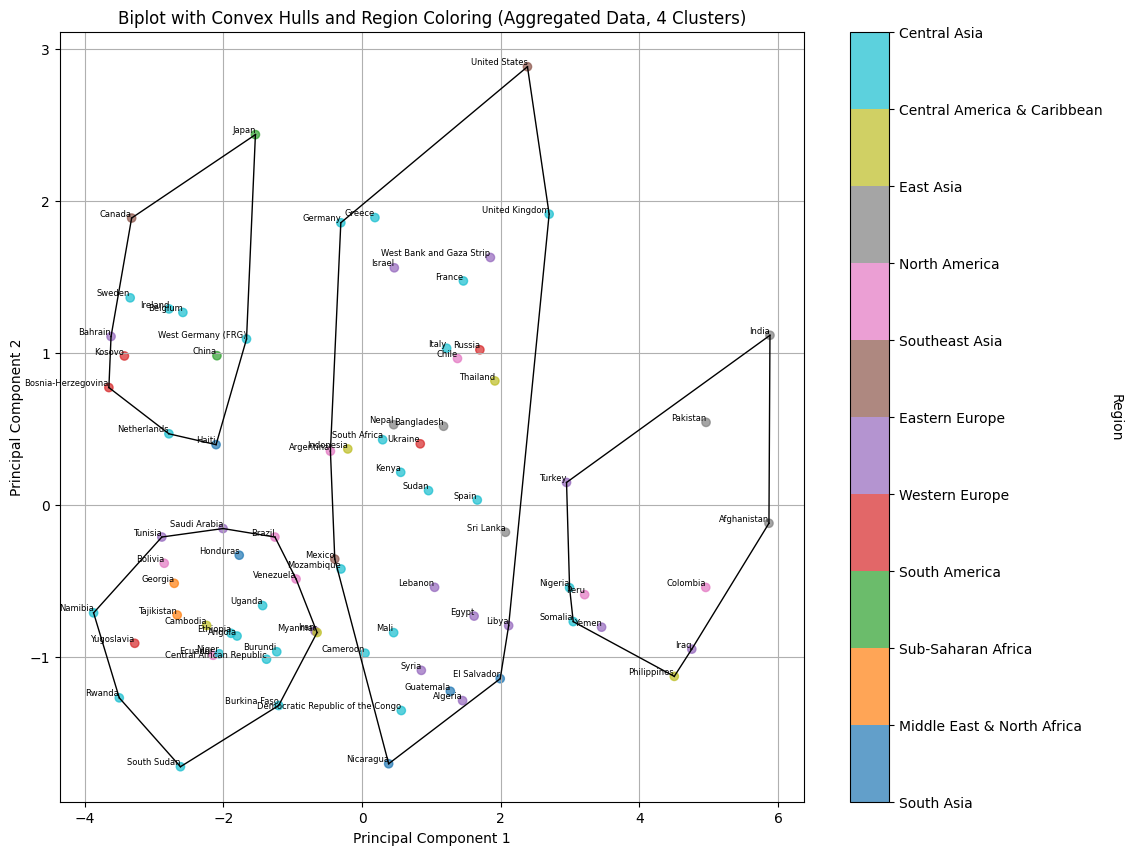

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial import ConvexHull
import numpy as np

# Assuming df_combined_agg is already calculated and available

# Convert region_txt to a categorical type and get numeric codes
df_combined_agg['region_category'] = df_combined_agg['region_txt'].astype('category')
df_combined_agg['region_code'] = df_combined_agg['region_category'].cat.codes + 1  # Start from 1

# Separate labels and features
labels_agg = df_combined_agg['region_category']
features_pca = df_combined_agg[['PC1', 'PC2']]

# Optimize the number of clusters using the elbow method
distortions = []
sil_scores = []
max_clusters = 10  # You can adjust the maximum number of clusters
for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features_pca)
    distortions.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(features_pca, kmeans.labels_))

# Choose the optimal number of clusters based on the elbow method or silhouette score
optimal_clusters = 4  # Adjust based on the analysis of the elbow curve or silhouette score

# Apply KMeans clustering with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels_optimal = kmeans_optimal.fit_predict(features_pca) + 1  # Start from 1

# Add cluster labels to the DataFrame
df_with_clusters_optimal = pd.concat([df_combined_agg, pd.DataFrame({'Cluster': cluster_labels_optimal})], axis=1)

# Plotting the biplot with colors representing region_txt and convex hulls for clusters
def biplot_convex_hulls(df, x_pc, y_pc, color_by=None, cluster_by=None, labels=None):
    plt.figure(figsize=(12, 10))

    # Plot points colored by region_txt
    scatter = plt.scatter(df[x_pc], df[y_pc], c=df[color_by].cat.codes, cmap='tab10', alpha=0.7, label=None)

    # Plot convex hulls around cluster points
    for cluster in df[cluster_by].unique():
        cluster_points = df[df[cluster_by] == cluster][[x_pc, y_pc]]
        hull = ConvexHull(cluster_points)
        for simplex in hull.simplices:
            plt.plot(cluster_points.iloc[simplex, 0], cluster_points.iloc[simplex, 1], 'k-', color='black', linewidth=1)

    # Add tiny labels for country_txt on each point
    for i, country in enumerate(df[labels]):
        plt.text(df[x_pc][i], df[y_pc][i], country, color='black', ha='right', va='bottom', fontsize=6)

    # Add colorbar for region_txt
    cbar = plt.colorbar(scatter, label='Region', ticks=np.arange(len(df[color_by].unique())))
    cbar.set_label('Region', rotation=270, labelpad=15)
    cbar.set_ticklabels(df[color_by].unique())  # Set tick labels for readability

    # Add a readable legend for region_txt
    regions = df[color_by].unique()
    region_labels = {region: f'{region}\n' for region in regions}
    legend_labels = [region_labels[region] for region in df[color_by].unique()]
    #plt.legend(legend_labels, title='Region', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')

    plt.xlabel(f'Principal Component 1')
    plt.ylabel(f'Principal Component 2')
    plt.title(f'Biplot with Convex Hulls and Region Coloring (Aggregated Data, {optimal_clusters} Clusters)')
    plt.grid()
    plt.show()

# Call the biplot function with the aggregated DataFrame and cluster labels
biplot_convex_hulls(df_with_clusters_optimal, 'PC1', 'PC2', color_by='region_category', cluster_by='Cluster', labels='country_txt')


## time series

In [153]:
import pandas as pd
refugee = pd.read_csv(filepath_or_buffer='data/population.csv', delimiter= ',')


df_tot = refugee.groupby("Year")["Refugees under UNHCR's mandate"]\
    .sum().reset_index().merge(
    df.groupby("iyear")[["nkill","nwound"]].sum().reset_index(),
    how = "inner",
    left_on= "Year", 
    right_on="iyear"
)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1499.680, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1502.360, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1496.932, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1498.980, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1505.991, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1497.987, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1498.879, Time=0.14 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1498.671, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1496.671, Time=0.10 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1498.670, Time=0.14 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1500.669, Time=0.26 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1499.590, Time=0.02 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=1495.734, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1498.341, Time=0.02 sec
 ARIMA(2,1,0)(1,0,1

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Non-invertible starting seasonal moving average Using zeros as starting parameters.
 This problem is unconstrained.



At iterate   30    f=  1.48770D+01    |proj g|=  1.94433D-02

At iterate   35    f=  1.48764D+01    |proj g|=  5.49431D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     44      1     0     0   3.920D-07   1.488D+01
  F =   14.876431091587676     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


No supported index is available. Prediction results will be given with an integer index beginning at `start`.
No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.


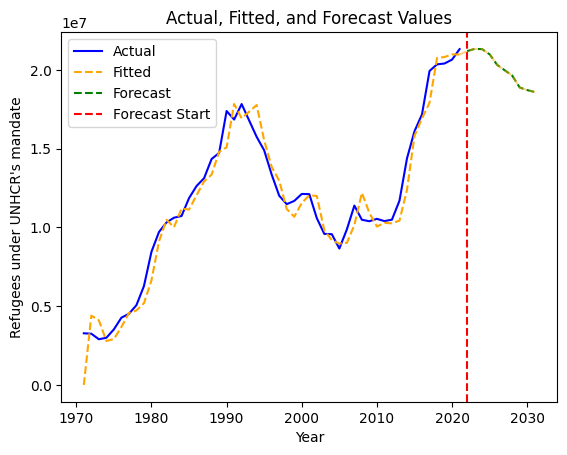

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# Assuming df_tot is your DataFrame
# Convert 'iyear' to datetime and set it as the index
df_tot['iyear'] = pd.to_datetime(df_tot['iyear'], format='%Y')
df_tot.set_index('iyear', inplace=True)

# 1. Prepare the Data
# Create lag features
df_tot['Refugees_lag1'] = df_tot['Refugees under UNHCR\'s mandate'].shift(1)
df_tot['nkill_lag1'] = df_tot['nkill'].shift(1)
df_tot['nwound_lag1'] = df_tot['nwound'].shift(1)

# Drop missing values resulting from lag operations
df_tot.dropna(inplace=True)

# 2. Optimize Order and Seasonal Order
# Using auto_arima to find optimal order and seasonal order
model = auto_arima(df_tot['Refugees under UNHCR\'s mandate'], exogenous=df_tot[['nkill_lag1', 'nwound_lag1']],
                   start_p=1, start_q=1, max_p=3, max_q=3, m=12, seasonal=True, trace=True)

# 3. Build a Time Series Forecasting Model with SARIMAX
endog_col = 'Refugees under UNHCR\'s mandate'
exog_cols = ['nkill_lag1', 'nwound_lag1']

# Specify exogenous variables separately
exog = df_tot[exog_cols]
endog = df_tot[endog_col]

model = SARIMAX(endog, order=model.order, seasonal_order=model.seasonal_order, exog=exog)
result = model.fit()

# 4. Get Fitted Values
fitted_values = result.fittedvalues

# 5. Specify 10 New Points for Forecasting
new_exog_data = pd.DataFrame({
    'nkill_lag1': [200] * 10,
    'nwound_lag1': [200] * 10
}, index=pd.date_range(start=df_tot.index[-1] + pd.DateOffset(years=1), periods=10, freq='YS'))

# 6. Make a 10-year Forecast
forecast_steps = 10
forecast = result.get_forecast(steps=forecast_steps, exog=new_exog_data)

# 7. Visualize Actual, Fitted, and Forecast Values
plt.plot(df_tot.index, df_tot[endog_col], label='Actual', color='blue')
plt.plot(df_tot.index, fitted_values, label='Fitted', linestyle='--', color='orange')

# Plot Forecast
forecast_index = pd.date_range(start=df_tot.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='YS')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', linestyle='--', color='green')

# Plot Forecast Start Line
plt.axvline(x=forecast_index[0], linestyle='--', color='red', label='Forecast Start')

# Connect Fitted and Forecast Curves
plt.plot(forecast_index.insert(0, df_tot.index[-1]), [fitted_values.iloc[-1]] + forecast.predicted_mean.tolist(), linestyle='--', color='orange', alpha=0.5)

plt.xlabel('Year')
plt.ylabel(endog_col)
plt.title('Actual, Fitted, and Forecast Values')
plt.legend()
plt.show()


In [147]:
pd.date_range(start=df_tot.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='YS')


DatetimeIndex(['2022-01-01', '2023-01-01', '2024-01-01', '2025-01-01',
               '2026-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')